In [1]:
import numpy as np
#import scipy
import matplotlib
import math
from scipy import integrate, LowLevelCallable
from scipy.integrate import odeint,solve_ivp
from scipy.sparse import csc_matrix
import matplotlib.pyplot as plt
import os, ctypes
#import time
import timeit
matplotlib.rcParams['text.usetex'] = True
%config InlineBackend.figure_format = 'retina'

In [2]:
tic = timeit.default_timer()
# tic
# set global variables
global v, DB, DT, rhocp, cpg, rhog, Tw, Rr, DH, lH2, Dp, leff, eps     #;
global ki0, K0, Q, EB, R_kcal, R_J, kd0, Ed, MT                    #;
global Ptot, cBin, cTin, Tin, cHin, xHin                        #;
global z01, zL1, z02, zL2, z03, zL3, n1, n2, n3, z1, z2, z3           #;
global D1_1, D2_1, D1_2, alpha, rhoc                           #;
global D2_2, D1_3, D2_3                                      #;

# model parameters
# experiment G3 (catalyst pretreatment first)

Ptot = 1e5              #; %total pressure (Pa)
Tin = 160 + 273.16      #; % inlet temperature (K)
T0 = 160 + 273.16       #; % initial temperature (K)
Tw = 29 + 273.16        #; % wall temperature (K)
xBin = 0                #; % mole fraction benzene
R_kcal = 1.987          #; % gas constant (kcal/kmol K)
R_J = 8.314e3           #; %gas constant (J/kmol K)

cBin = xBin*Ptot / ( R_J*Tin )         # ;
xHin = 1                               #; % mole fraction hydrogen
cHin = xHin*Ptot / ( R_J*Tin )         #;
xTin = 0                               # ; % mole fraction thiophene
cTin = xTin*Ptot / ( R_J*Tin )         # ;
flow = 1551.5e-6/60                    #; % total flow rate (m^3/s)
theta0 = 1                             #;

#%
DB = 4e-5                              #; % diffusion coefficients (m^2/s)
DT = 4e-5                              #;
eps = 0.6                              # ; % void fraction

#%
MW = 2.106*xHin + 78.12*xBin           #; % molar weight of the gas

#% mixture (kg/kmol)
rhog = MW*273.16*Ptot*0.0075/(22.41*760*Tin )    #; % gas dens
                                                 #% (kg/m^3)
cpg = 6.935*xHin + 23.15*xBin                    #; % heat capacity of the gas
                                                 #% (kcal/kg K)
rhocp = 175                                      #; % average heat capacity
                                                 #% (kcal/m^3 K)
lH2 = 733*0.019/(100*3600)                       #; % thermal conductivity of the
                                                 #% gas (kcal/s m K)
rhoc = 354*2/3                                   #; % catalyst density (kg/m^3) with a
                                                 #% dilution factor of 2
Dp = 1.25e-3                                     #; % particle diameter (m) (average between
                                                 #% 0.75 and 1.8 mm)
Rr = 0.822e-2                                     #; % reactor radius (m)
SA = np.pi*Rr**2                                      #; % cross−section area (m^2)
v = flow / ( eps*SA )                             #; % intersticial velocity (m/s)
leff = 7*lH2 + 0.8*rhog*cpg*v*eps*Dp              #; % effective thermal
                                                  #% conductivity (kcal/s m K)
alpha = 2.6e-3                                    #; % heat transfer coefficient (kcal/m^2 K)

#%benzene hydrogenation kinetics
EB = 13770                                        #; % activation energy (kcal/kmol)

ki0 = 4.22* 0.0075                                #; % rate constant (kmol/kg s Pa)
Q = -16470                                        #; % heat of adsorption (kcal/kmol)
K0 = 4.22e-11*0.0075                              #; % adsorption constant ( 1 /torr)

#%
#%thiophene poisoning kinetics

Ed = 1080                                          #; % activation energy (kcal/kmol)
kd0 = 2.40e-2*0.0075                               #; % pre−exponential factor ( 1 / Pa s)
MT = 1.03e-3                                       #; % catalyst adsorption capacity for

#% thiophene (kmol/kg)

DH = 49035                                         #; % heat of reaction (kcal/kmole)

#% spatial grid
L = 0.5                                             #; % reactor length (m)
z01 = 0.0                                           #;
zL1 = 0.14                                          # ; % entrance (inert) section
z02 = zL1                                           #;
zL2 = z02 + 0.095                                   #; % catalyst section
z03 = zL2                                           #;
zL3 = L                                             #; %exit (inert) section
n1 = 71                                             #;
n2 = 71                                             #;
n3 = 71                                             #;
dz1 = (zL1-z01) / (n1-1)                          #;
dz2 = (zL2-z02) / (n2-1)                          #;
dz3 = (zL3-z03) / (n3-1)                          #;
# v   = 0.203                                       # intersticial velocity, m/s
num_x = 0.00001                                   # a small added to separate reactor zones

z1 = np.arange(z01,zL1+num_x,dz1,dtype= float)[:, np.newaxis]                       #' ;
z2 = np.arange(z02,zL2+num_x,dz2,dtype= float)[:, np.newaxis]                       #' ;
z3 = np.arange(z03,zL3+num_x,dz3,dtype= float)[:, np.newaxis]                       #' ;
z  = np.concatenate((z1,z2,z3), axis=0)

In [3]:
def weights(zd,zs,ns,m):
        
    # input Parameters
    
    # zd, location where the derivative is to be computed
    # ns, number of points in the stencil    
    # zs(ns), stencil of the finite difference scheme
    # m, highest derivative for which weights are sought
    # output Parameter
    # w(1:ns,1:m+1), weights at grid locations z(1:ns) for derivatives
    # of order 0:m, found in w(1:ns,1:m+1)
    
    c1 = 1.0
    c4 = zs[0]-zd
    
    w = np.zeros((ns,m+1))
    w[0,0] = 1.0
    
    for i in range(1,ns):
        mn = min(i,m)
        c2 = 1.0
        c5 = c4
        c4 = zs[i]-zd
        
        for j in range(i):
            c3 = zs[i]-zs[j]
            c2 = c2*c3
            
            if j==i-1:
                for k in range(mn,0,-1):
                    w[i,k] = c1*(k*w[i-1,k-1] - c5*w[i-1,k])/c2
                w[i,0] = -c1*c5*w[i-1,0]/c2
                
            for k in range(mn,0,-1):
                w[j,k] = (c4*w[j,k] - k*w[j,k-1])/c3
            w[j,0] = c4*w[j,0]/c3
        c1 = c2
    
    return w

In [4]:
def five_point_biased_upwind_D1(z,v):
    
    m=1
    ns=5
    #sparse discretization matrix
    
    n = len(z)
    #D = sparse(n,n), from matlab
    D = csc_matrix((n,n), dtype= float).toarray()
    #(1)  finite difference approximation for positive v
    
    if (v > 0):
        #boundary conditions
        zs = z[0:ns]
        for i in range(0,3):
            zd = z[i]
            w = weights(zd,zs,ns,m)
            D[i,0:ns] = w[0:ns,m] #.T
            
        # interior points
        for i in range(3,n-1):
            zs = z[i-3:i+2]
            zd = z[i]
            w  = weights(zd,zs,ns,m)
            D[i,i-3:i+2]=w[0:ns,m]# m is calculate
            
        #boundary point
        zs = z[n-ns:n]
        zd = z[n-1]
        w  = weights(zd,zs,ns,m)
        D[n-1,n-ns:n] = w[0:ns,m]
            
    #(2)  finite difference approximation for negative v
    if (v < 0):
        # boundary point
        zs = z[0:ns]
        zd = z[0]
        w  = weights(zd,zs,ns,m)
        D[0,0:ns] = w[0:ns,m] # these need to be transposed!
        
        # interior points
        for i in range(1,n-2):            
            zs = z[i-1:i+4]
            zd = z[i]
            w  = weights(zd,zs,ns,m)
            D[i,i-1:i+4] = w[0:ns,m] # can be checked later
            
        # boundary points
        zs = z[n-ns:n] # Check later the indices
        for i in range(3,0,-1):
            zd = z[n-i]
            w  = weights(zd,zs,ns,m)
            D[n-i,n-5:n]= w[0:ns,m]            
    return D

In [5]:
#D1 = five_point_biased_upwind_D1(z,v)

In [6]:
def five_point_centered_D2(z):
    
    # parameters
    m=2                # highest derivative for which weights are sought
    ns=5               # number of points in the stencil
    
    # sparse discretization matrix
    
    n = len(z)
    #D = sparse(n,n)
    D = csc_matrix((n,n), dtype= float).toarray()
    
    # boundary points
    
    zs = z[0:ns]
    
    for i in range(0,2):
        zd = z[i]
        w = weights(zd,zs,ns,m)
        D[i,0:ns] = w[0:ns,m] # need to check the orientation whether transpose is needed
        
        
    # interior points
    for i in range(2,n-2):
        zs = z[i-2:i+3]
        zd = z[i]
        w  = weights(zd,zs,ns,m)
        D[i,i-2:i+3]=w[0:ns,m] # check this later
    
    
    # boundary points 
    zs = z[n-ns:n]
    
    for i in range(2,0,-1): 
        zd = z[n-i]
        w  =  weights(zd,zs,ns,m)
        D[n-i,n-5:n]=w[0:ns,m] # check the return matrix
    
    return D

In [7]:
def three_zone_reactor_pdes_preheat(t,x):
    # set global variables
    global v,DB,DT,rhocp,cpg,rhog,Tw,Rr,DH,lH2,Dp,leff,eps
    global ki0,K0,Q,EB,R_kcal,R_J,kd0,Ed,MT
    global Ptot,cBin,cTin,Tin,cHin,xHin
    global z01,zL1,z02,zL2,z03,zL3,n1,n2,n3,z1,z2,z3
    global alpha,rhoc,D1_1,D2_1,D1_2
    global D2_2,D1_3,D2_3
    
    # Transfer dependent variables
    
    cB1 = x[0: 3*n1-2: 3]
    cT1 = x[1: 3 *n1-1: 3]
    T1  = x[2: 3 *n1: 3] 
    #print(T1.shape)
    #
    cB2 = x[3*n1: 3*n1+4*n2-3: 4]
    cT2 = x[3*n1+1: 3*n1+4*n2-2: 4]
    T2 =  x[3*n1+2: 3*n1+4*n2-1: 4]
    theta = x[3*n1+3: 3*n1+4*n2: 4]
    #print(theta)
    #
    cB3 = x[3*n1+4*n2: 3*n1+4*n2+3*n3-2: 3]
    cT3 = x[3*n1+4*n2+1: 3*n1+4*n2+3*n3-1: 3]
    T3  = x[3*n1+4*n2+2: 3*n1+4*n2+3*n3: 3]
    #print(T3.shape)
    # spatial derivatives − 1st zone
    cB1z = D1_1@cB1
    cT1z = D1_1@cT1
    T1z = D1_1@T1
    #print(T1z.shape)
    #
    cB1zz = D2_1@cB1
    cT1zz = D2_1@cT1
    T1zz = D2_1@T1
    #print(T1zz.shape)
    # spatial derivatives − 2nd zone
    cB2z = D1_2@cB2
    cT2z = D1_2@cT2
    T2z = D1_2@T2
    #print(T2z.shape)
    #print(D1_2.shape)
    #
    cB2zz = D2_2@cB2
    cT2zz = D2_2@cT2
    T2zz = D2_2@T2
    #print(T2zz.shape)
    # spatial derivatives − 3rd zone
    cB3z = D1_3@cB3
    cT3z = D1_3@cT3
    T3z = D1_3@T3
    #print(T3zz.shape)
    #
    cB3zz = D2_3@cB3
    cT3zz = D2_3@cT3
    T3zz = D2_3@T3
    #print(T3zz.shape)
    # several operating conditions
    # 1) catalyst pretreatment with hydrogen at 160 Celsius
    # (for 20 min)
    rB = 0      # reaction rates in 2nd zone
    rd = 0
    rT = 0
    # 2) benzene hydrogenation (experiment G3)
    
    if (t > 20* 60) & (t < 30* 60):
        #
        Tin = 160 + 273.16               # inlet temperature (K)
        xBin = 2*0.033                   # mole fraction benzene
        cBin = xBin*Ptot / (R_J*Tin)
        xHin = 1-xBin                    # mole fraction hydrogen
        cHin = xHin*Ptot / (R_J*Tin)
        xTin = 0                         # mole fraction thiophene
        cTin = xTin*Ptot / (R_J*Tin)         
        #
        MW = 2.106*xHin + 78.12*xBin     #gas mixture molar
        # weight (kg/kmol)
        rhog = MW*273.16*Ptot*0.0075/(22.41*760*Tin)    # density
        cpg = 6.935*xHin + 23.15*xBin                    # heat capacity of the % gas (kcal/kg K)
        leff = 7*lH2 + 0.8* rhog*cpg*v*eps*Dp        
        #
        xB2 = cB2 /(cB2+cT2+cHin)                     # reaction rates 2nd zone
        rB = ki0*K0*Ptot**2*(xHin*xB2*theta*np.exp((-Q -EB)/(R_kcal*T2)))/ \
        (1 + K0*Ptot*xB2 * np.exp(-Q/(R_kcal*T2)))
        rd = 0
        rT = 0
    elif (t > 60*120):
        Tin = 160 + 273.16                 # inlet temperature (K)
        xBin = 2*0.033                     # mole fraction benzene
        cBin = xBin*Ptot / (R_J*Tin)
        xHin = 1-xBin                      # mole fraction hydrogen
        cHin = xHin*Ptot / (R_J*Tin)
        xTin = 1.136*xBin/ 100             # mole fraction thiophene
        cTin = xTin*Ptot / (R_J*Tin)
        #
        MW = 2.106*xHin + 78.12*xBin       # gas mixture molar
        # weight (kg/kmol)
        rhog = MW*273.16*Ptot*0.0075/(22.41*760*Tin)     # gas
        
        # density
        cpg = 6.935*xHin + 23.15*xBin          # heat capacity of the gas (kcal/kg K)
        leff = 7*lH2 + 0.8* rhog*cpg*v*eps*Dp
        xB2 = cB2 /(cB2+cT2+cHin)               # reaction rates 2nd zone
        xT2 = cT2 / (cB2+cT2+cHin)
        rB = ki0*K0*Ptot**2*(xHin*xB2*theta*np.exp((-Q -EB )/( R_kcal*T2)))/ \
        (1 + K0*Ptot*xB2* np.exp(-Q/(R_kcal*T2)))
        rd = kd0*Ptot*xT2* theta* np.exp(-Ed/( R_kcal*T2))
        rT = MT*rd
    
    # temporal derivatives
    cB1t = -v*cB1z + DB*cB1zz
    cT1t = -v*cT1z + DT*cT1zz
    T1t = -((eps*v*rhog*cpg ) / rhocp)*T1z + (leff/rhocp)*T1zz + 2*alpha*(Tw - T1 ) / (Rr*rhocp)
    #
    #print(T1t.shape)
    #
    cB2t = -v*cB2z + DB*cB2zz - rhoc*rB/eps
    cT2t = -v*cT2z + DT*cT2zz - rhoc*rT/eps
    T2t = -((eps*v*rhog*cpg)/rhocp)*T2z + (leff/rhocp)*T2zz + 2*alpha*(Tw - T2)/(Rr*rhocp) + (DH/rhocp)*rhoc*rB
    thetat = -rd
    #
    #print(T2t.shape)
    #
    cB3t = -v*cB3z + DB*cB3zz
    cT3t = -v*cT3z + DT*cT3zz
    T3t = -((eps*v*rhog*cpg) / rhocp)*T3z + (leff/rhocp)*T3zz + 2*alpha*(Tw - T3) / (Rr*rhocp)
    # boundary conditions at z = z01
    cB1t[0] = cBin - cB1[0]
    cT1t[0] = cTin - cT1[0]
    T1t[0]  = Tin - T1[0]
    #print(T1t)
    # boundary conditions at z = zL1 = z02
    cB1t[n1-1] = cB2z[0] - cB1z[n1-1]
    cT1t[n1-1] = cT2z[0] - cT1z[n1-1]
    T1t[n1-1]  = T2z[0] - T1z[n1-1]
    
    #
    cB2t[0] = cB1[n1-1] - cB2[0]
    cT2t[0] = cT1[n1-1] - cT2[0]
    T2t[0]  = T1[n1-1] - T2[0]
    
    #boundary conditions at z = zL2 = z03
    cB2t[n2-1] = cB3z[0] - cB2z[n2-1]
    cT2t[n2-1] = cT3z[0] - cT2z[n2-1]
    T2t[n2-1]  = T3z[0] - T2z[n2-1]
    #
    cB3t[0] = cB2[n2-1] - cB3[0]
    cT3t[0] = cT2[n2-1] - cT3[0]
    T3t[0]  = T2[n2-1] - T3[0]
    # 3) catalyst poisoning (experiment G3)
    #boundary conditions at z = zL
    cB3t[n3-1] = - cB3z[n3-1]
    cT3t[n3-1] = - cT3z[n3-1]
    T3t[n3-1]  = - T3z[n3-1]
    #
    #initialize xt, output derivatives
    xt = np.empty_like(x)
    
    # Transfer temporal derivatives
    xt[0: 3*n1-2: 3] = cB1t
    xt[1: 3 *n1-1: 3] = cT1t
    xt[2: 3 *n1: 3] = T1t
    #
    xt[3*n1: 3*n1+4*n2-3: 4] = cB2t
    xt[3*n1+1: 3*n1+4*n2-2: 4] = cT2t
    xt[3*n1+2: 3*n1+4*n2-1: 4] = T2t
    xt[3*n1+3: 3*n1+4*n2: 4] = thetat
    #
    xt[3*n1+4*n2: 3*n1+4*n2+3*n3-2: 3] = cB3t
    xt[3*n1+4*n2+1: 3*n1+4*n2+3*n3-1: 3] = cT3t
    xt[3*n1+4*n2+2: 3*n1+4*n2+3*n3: 3] = T3t
    
    return xt

In [8]:
#% differentiation matrix in zone 1 (convective and
#% diffusive terms)

D1_1 = five_point_biased_upwind_D1(z1 , v )                 #;
D2_1 = five_point_centered_D2(z1 )                          #;

#% differentiation matrix in zone 2 (convective and
#% diffusive terms)

D1_2 = five_point_biased_upwind_D1(z2 , v )                 #;
D2_2 = five_point_centered_D2(z2 )                          #;

#% differentiation matrix in zone 3 (convective and
#% diffusive terms)

D1_3 = five_point_biased_upwind_D1(z3 , v )                 #;
D2_3 = five_point_centered_D2(z3 )                          #;



In [9]:
#% initial conditions
cB1 = cBin*np.ones(z1.shape[0])                              #; z1.shape[0]
cT1 = cTin*np.ones(z1.shape[0])                               #;
T1 = T0*np.ones(z1.shape[0])                                  #;
cB2 = cBin*np.ones(z2.shape[0])                               #;
cT2 = cTin*np.ones(z2.shape[0])                               #;
T2 = T0*np.ones(z2.shape[0])                                  #;
theta = theta0*np.ones(z2.shape[0])                           #;
cB3 = cBin*np.ones(z3.shape[0])                               #;
cT3 = cTin*np.ones(z3.shape[0])                               #;
T3 = T0*np.ones(z3.shape[0])                                  #;


In [10]:
#x = np.ones((n1*3+n2*4+n3*3)) # initialize output parameters

In [11]:
x0 = np.ones((n1*3+n2*4+n3*3)) # initialize output parameters

In [12]:
#% initial conditions in x
x0[0: 3*n1-2: 3] = cB1
x0[1: 3 *n1-1: 3] = cT1
x0[2: 3 *n1: 3] = T1
x0[3*n1: 3*n1+4*n2-3: 4] = cB2
x0[3*n1+1: 3*n1+4*n2-2: 4] = cT2
x0[3*n1+2: 3*n1+4*n2-1: 4] = T2
x0[3*n1+3: 3*n1+4*n2: 4] = theta
x0[3*n1+4*n2: 3*n1+4*n2+3*n3-2: 3] = cB3
x0[3*n1+4*n2+1: 3*n1+4*n2+3*n3-1: 3] = cT3
x0[3*n1+4*n2+2: 3*n1+4*n2+3*n3: 3] = T3


In [13]:
# x0[0: 3*n1: 1].shape
# x0[3*n1: 3*n1+4*n2: 1].shape
# x0[3*n1+4*n2: 3*n1+4*n2+3*n3: 1].shape


In [14]:
# time span

t0 = 0
tf = 271
t_step = 1 # sec

t_span = 60*np.array([t0,tf])

t = 60*np.arange(t0,tf,t_step) 

In [15]:
soln = solve_ivp(three_zone_reactor_pdes_preheat,t_span,x0, method='Radau', t_eval= t, dense_output=True,\
                 vectorized = True)

In [16]:
# Method 'Radau' is working well in addition to 'BDF'

In [17]:
# Recover the temperature in the three zones
T1_out = soln.y[2: 3*n1: 3,:]                                                              
T2_out = soln.y[3*n1+2: 3*n1+4*n2-1: 4,:]
T3_out = soln.y[3*n1+4*n2+2: 3*n1+4*n2+3*n3: 3,:]                                  

# #% Assembly of temperature and spatial coordinates
T_out  =  np.concatenate((T1_out,T2_out,T3_out),axis=0) - 273.16
zz     =  np.concatenate((z1,z2,z3),axis=0)/ L


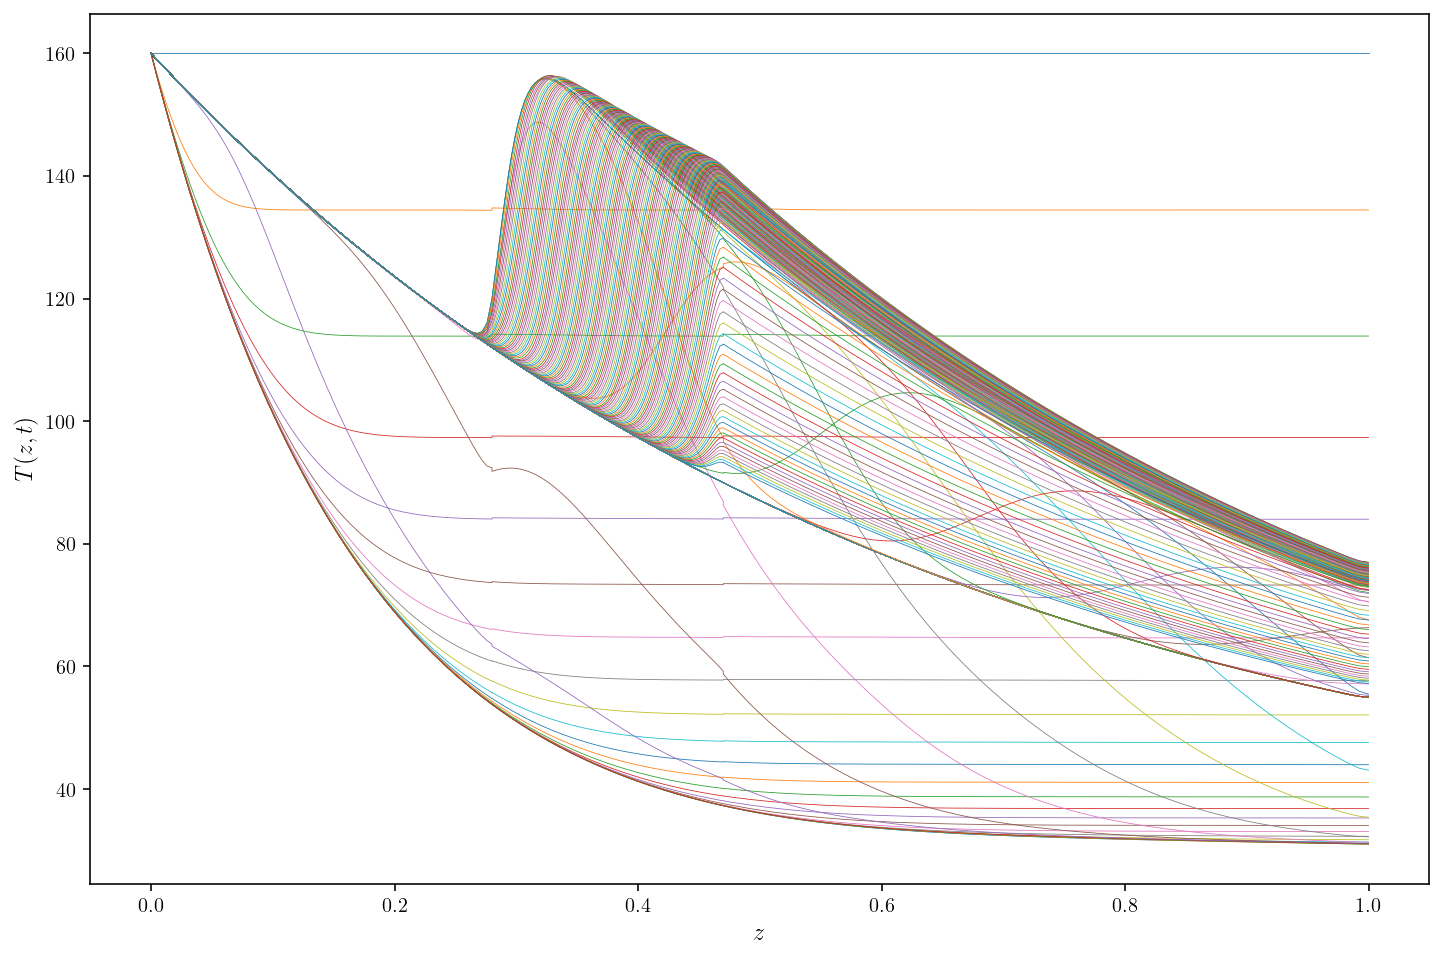

In [18]:
plt.figure(figsize = (12,8))
#plt.plot(soln.t)
plt.plot(zz,T_out,linewidth = 0.4)
plt.ylabel(r'$T(z,t)$',fontsize = 12)
plt.xlabel(r'$z$',fontsize = 12)
plt.show()

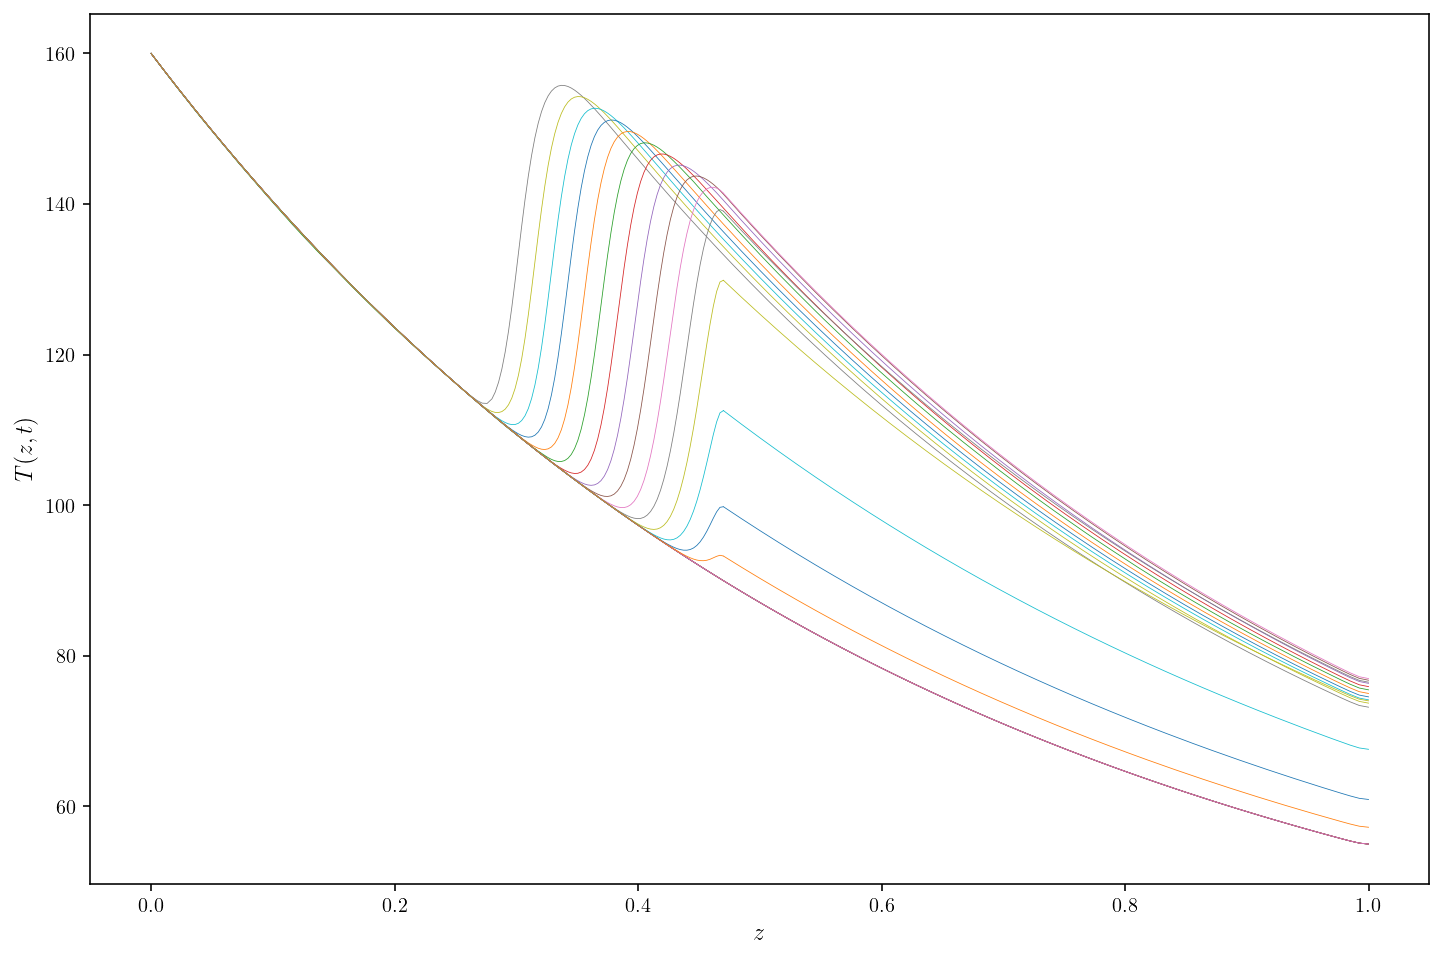

In [19]:
plt.figure(figsize = (12,8))
#plt.plot(soln.t)
plt.plot(zz,T_out[:,60::10],linewidth = 0.4)
plt.ylabel(r'$T(z,t)$',fontsize = 12)
plt.xlabel(r'$z$',fontsize = 12)
plt.show()

In [20]:
# Benzene concentration (xB)
xB1_out = soln.y[0: 3*n1-2: 3,:] /(soln.y[0: 3*n1-2: 3,:] + (soln.y[0: 3*n1-2: 3,:] + cHin))* 100
xB2_out = soln.y[3*n1: 3*n1+4*n2-3: 4,:] /(soln.y[3*n1: 3*n1+4*n2-3: 4,:] + (soln.y[3*n1: 3*n1+4*n2-3: 4,:]+cHin))* 100
xB3_out = soln.y[3*n1+4*n2: 3*n1+4*n2+3*n3-2: 3,:] /(soln.y[3*n1+4*n2: 3*n1+4*n2+3*n3-2: 3,:] + \
                                                 (soln.y[3*n1+4*n2: 3*n1+4*n2+3*n3-2: 3,:] + cHin))* 100

# combine for all reactor zones
xB_out = np.concatenate((xB1_out,xB2_out,xB3_out),axis=0)

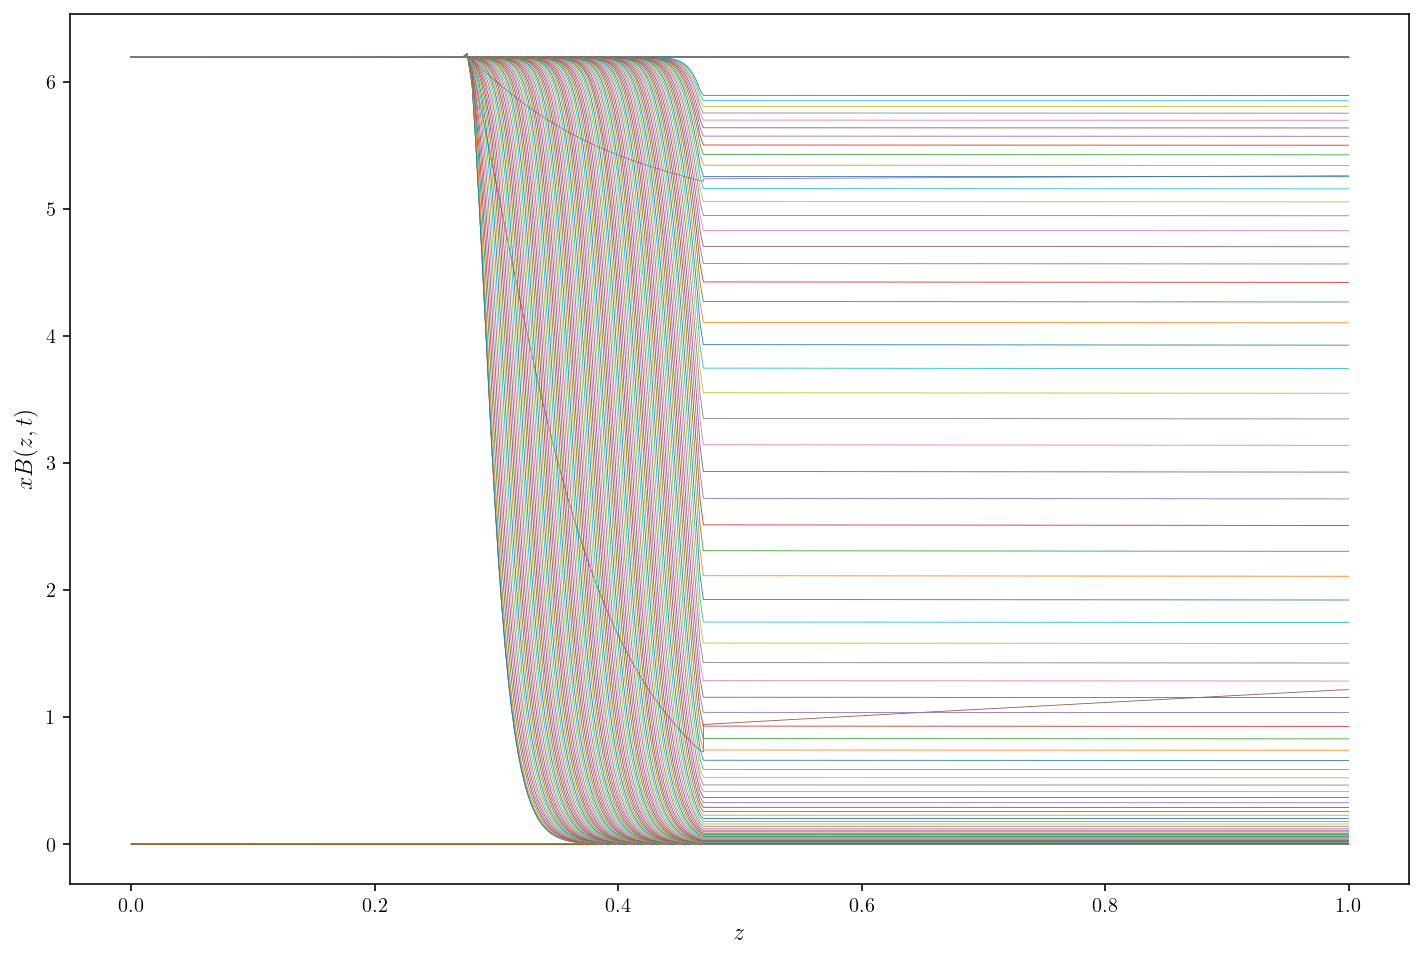

In [21]:
plt.figure(figsize = (12,8))
plt.plot(zz,xB_out,linewidth = 0.4)
plt.ylabel(r'$xB(z,t)$',fontsize = 12)
plt.xlabel(r'$z$',fontsize = 12)
plt.show()

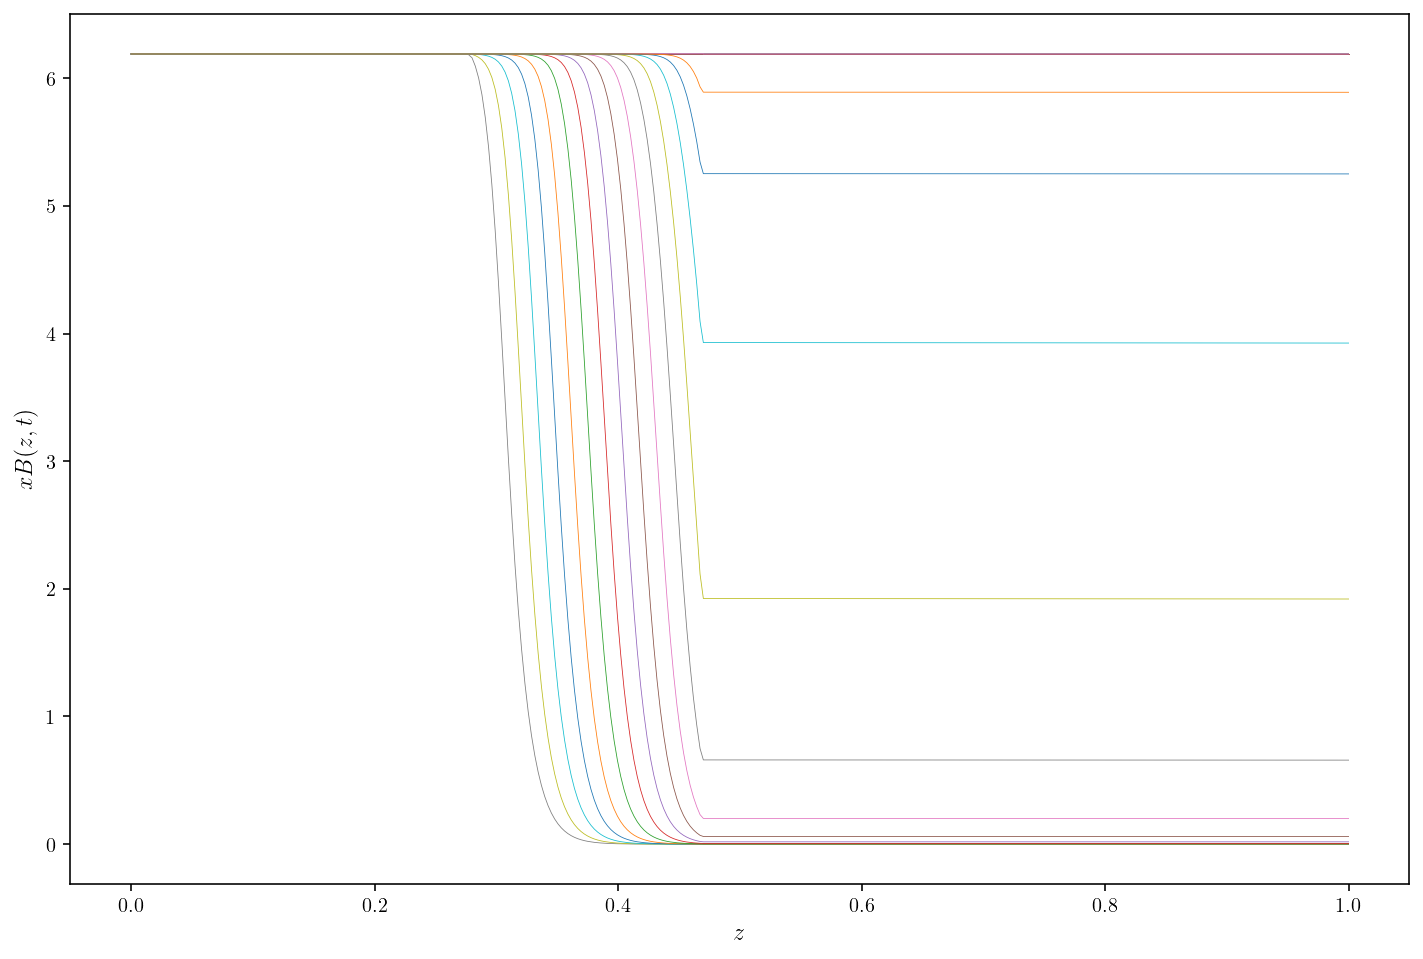

In [22]:
plt.figure(figsize = (12,8))
plt.plot(zz,xB_out[:,60::10],linewidth = 0.4)
plt.ylabel(r'$xB(z,t)$',fontsize = 12)
plt.xlabel(r'$z$',fontsize = 12)
plt.show()

In [23]:
# Thiophene concentration (xT)
xT1_out = soln.y[1: 3 *n1-1: 3,:]/(soln.y[1: 3 *n1-1: 3,:] + (soln.y[1: 3 *n1-1: 3,:]+cHin))* 1e4
xT2_out = soln.y[3*n1+1: 3*n1+4*n2-2: 4,:]/(soln.y[3*n1+1: 3*n1+4*n2-2: 4,:] + (soln.y[3*n1+1: 3*n1+4*n2-2: 4,:]+ cHin))* 1e4
xT3_out = soln.y[3*n1+4*n2+1: 3*n1+4*n2+3*n3-1: 3,:]/(soln.y[3*n1+4*n2+1: 3*n1+4*n2+3*n3-1: 3,:] + \
                                                      (soln.y[3*n1+4*n2+1: 3*n1+4*n2+3*n3-1: 3,:]+cHin))* 1e4

# combine for all the reactor zones
xT_out = np.concatenate((xT1_out, xT2_out, xT3_out), axis = 0)


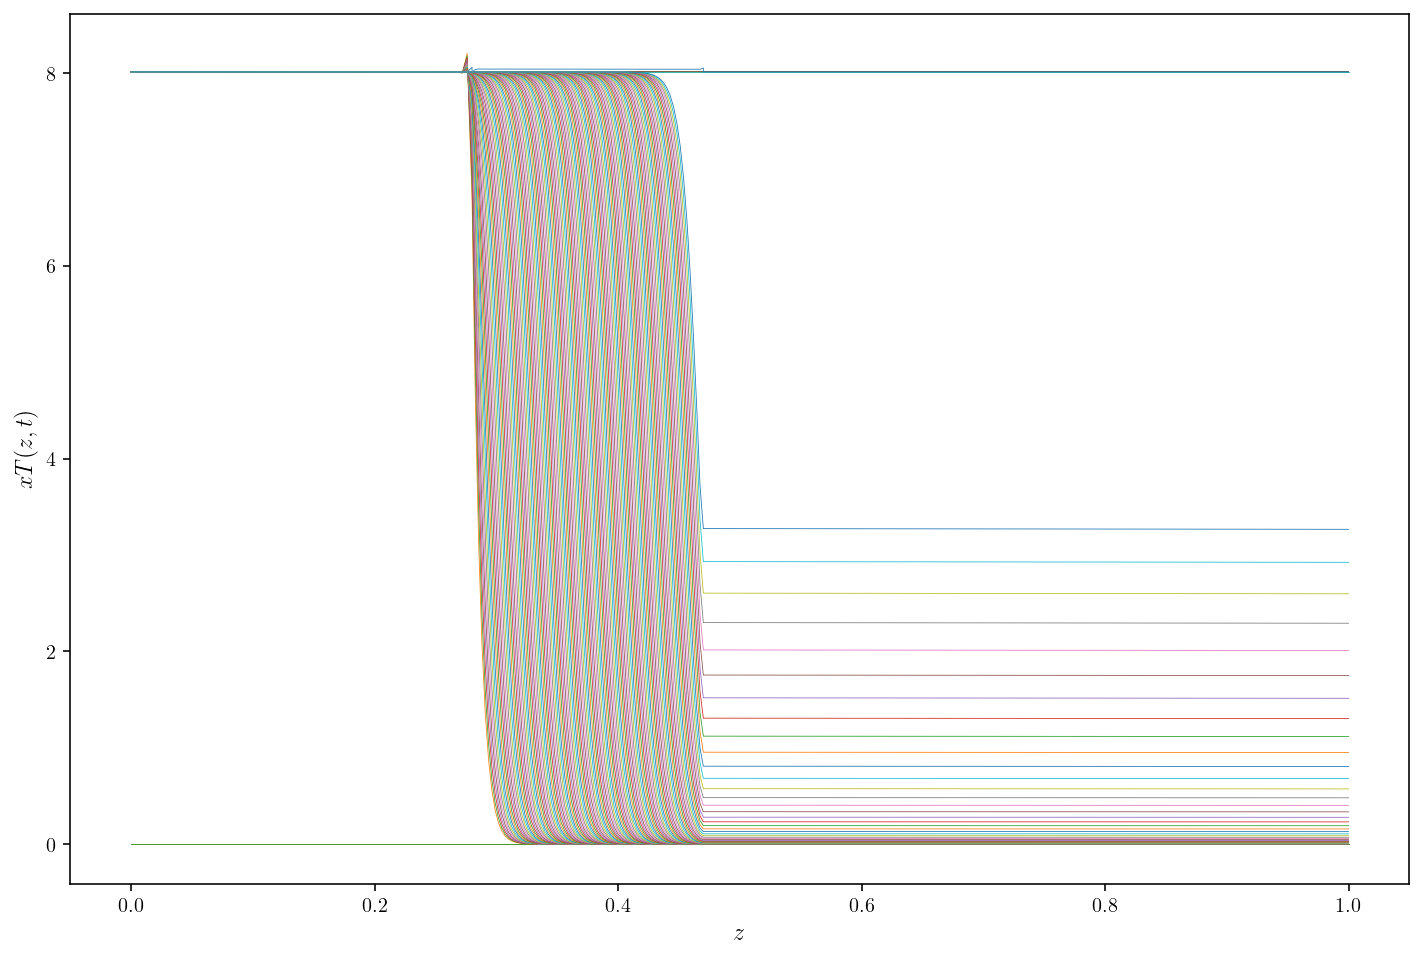

In [24]:
plt.figure(figsize = (12,8))
plt.plot(zz,xT_out,linewidth = 0.4)
plt.ylabel(r'$xT(z,t)$',fontsize = 12)
plt.xlabel(r'$z$',fontsize = 12)
plt.show()

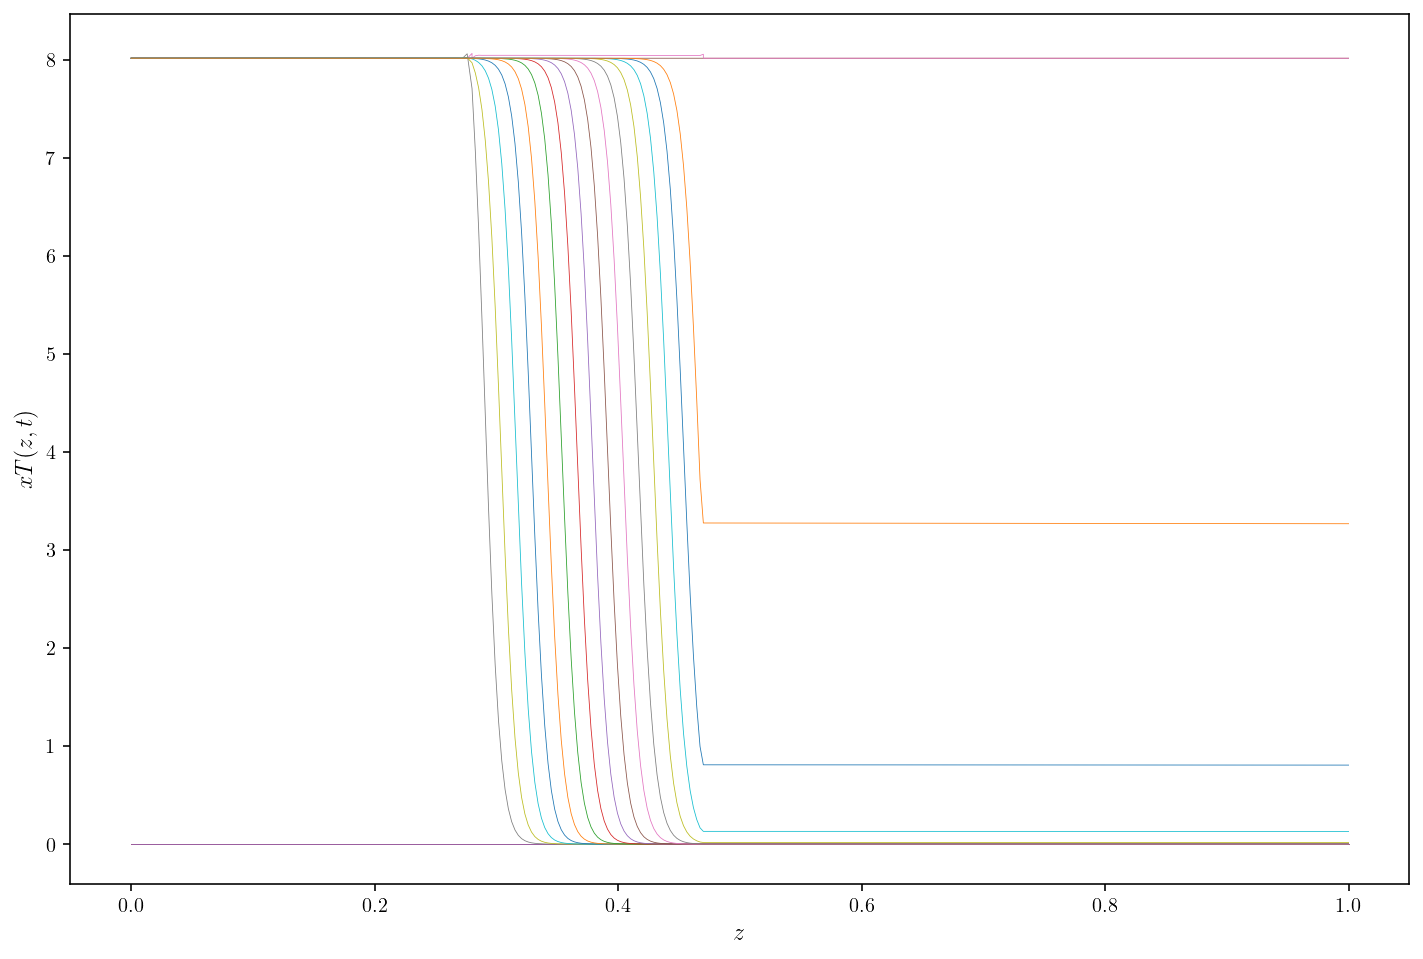

In [25]:
plt.figure(figsize = (12,8))
plt.plot(zz,xT_out[:,60::10],linewidth = 0.4)
plt.ylabel(r'$xT(z,t)$',fontsize = 12)
plt.xlabel(r'$z$',fontsize = 12)
plt.show()

In [26]:
# Catalyst activity
theta_out = soln.y[3*n1+3:3*n1+4*n2:4,:]
zL = z2/L

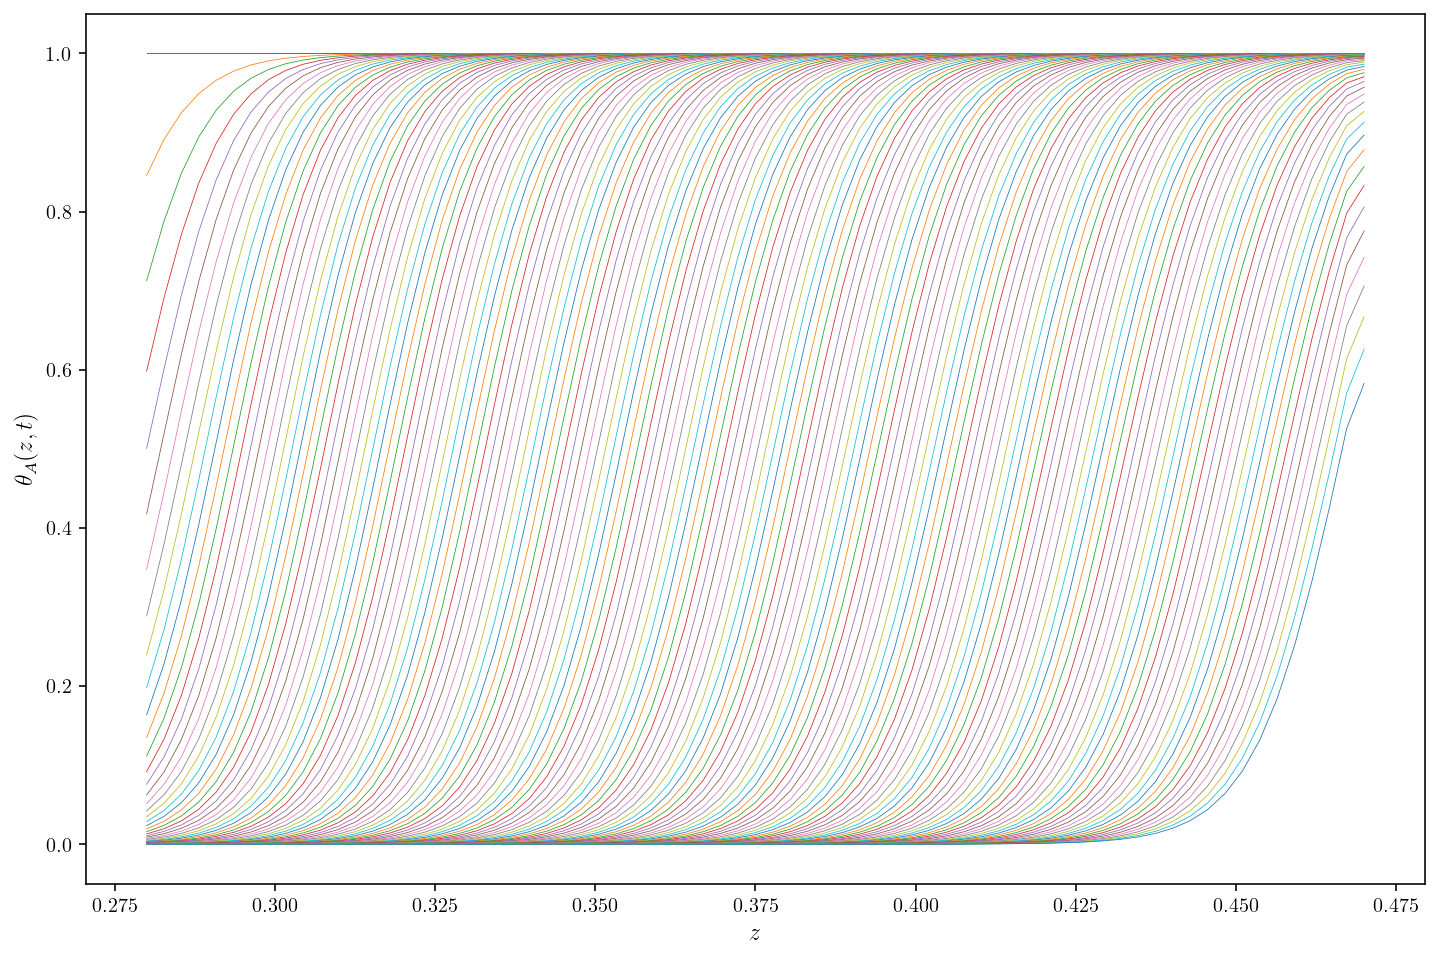

In [27]:
plt.figure(figsize = (12,8))
plt.plot(zL,theta_out,linewidth = 0.4)
plt.ylabel(r'$\theta_{A}(z,t)$',fontsize = 12)
plt.xlabel(r'$z$',fontsize = 12)
plt.show()

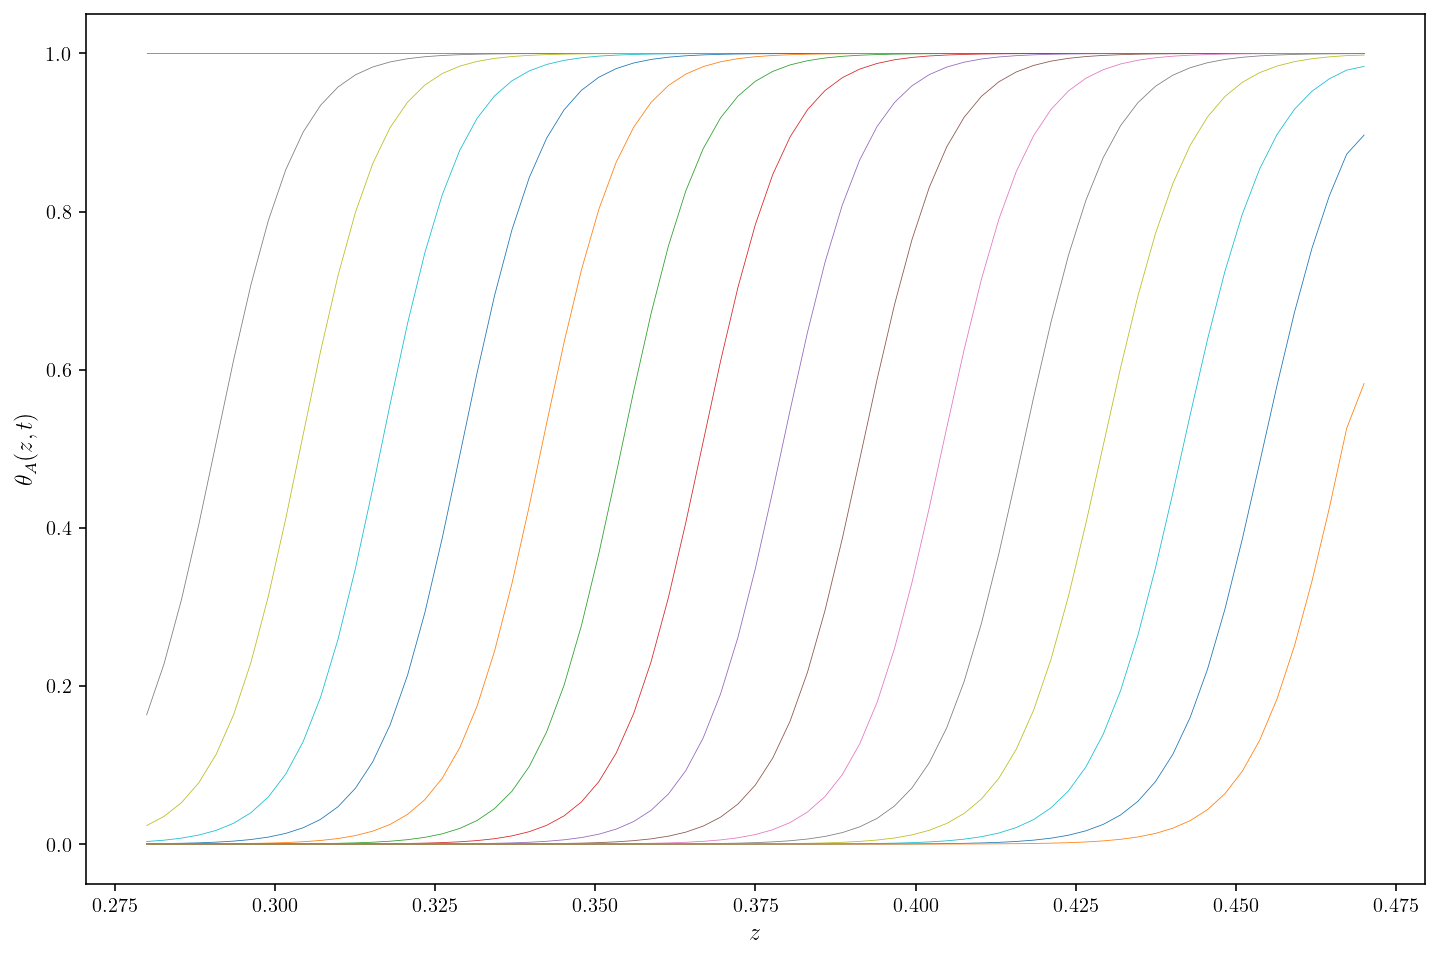

In [28]:
plt.figure(figsize = (12,8))
plt.plot(zL,theta_out[:,60::10],linewidth = 0.4)
plt.ylabel(r'$\theta_{A}(z,t)$',fontsize = 12)
plt.xlabel(r'$z$',fontsize = 12)
plt.show()

In [29]:
# fig, axs = plt.subplots(1,2,figsize = (8,4))
# #axs[0].plot(soln.y[1:])
# #axs[1].plot(soln.t, solc.y[2])
# plt.show()

In [30]:
#% read the stopwatch timer
toc = timeit.default_timer()
time_elapsed = toc - tic #elapsed time in seconds
print(time_elapsed)

13.949924825981725
